# Lab 2: Flame edge detection
-----
-----
## Introduction
In this lab, we will shift our attention to edge detection and how it can be used to locate flame fronts in OH-PLIF images. We will implement the state-of-the-art Canny edge detection algorithm step by step, then use it on a series of OH-PLIF images.
\
\
The detailed steps of the algorithm are available in the background section of [Chaib et al. 2023](https://doi.org/10.1007/s00348-023-03651-6). There are four steps overall with input parameters required at steps 1 and 4 : 
1) Gaussian filtering (input : standard deviation $\sigma$).\
2) Gradient computation.\
3) Non-maxima suppression.\
4) Hysteresis thresholding (input : thresholds $t_{low}$ and $t_{high}$).
\
\
***This notebook contains interactive widgets. Sliders can be used to visualize the effect of varying parameters. There may be a slight lag when moving these so make sure you do it one step at a time if possible.***\
\
Note: OpenCV likes uint8 format images so conversions are made accordingly throughout.

-----

We will start by loading the necessary modules. The set of functions used by the Canny edge detection algorithm is stored in `lab2_functions.py`. We will not go over the detailed implementation of each step in detail in this lab due to time constraints but feel free to check/edit the scripts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as wg
import lab2_functions as fun

We will first start by loading one of the images.

In [2]:
img_raw = cv2.imread("data/demo2.png",cv2.IMREAD_GRAYSCALE)
img_raw = 255*(img_raw/np.max(img_raw))
img_raw = img_raw.astype(np.uint8)

Before edge detection, filtering the image is necessary. We will be using an edge-preserving filter on the image prior to the edge detection process.

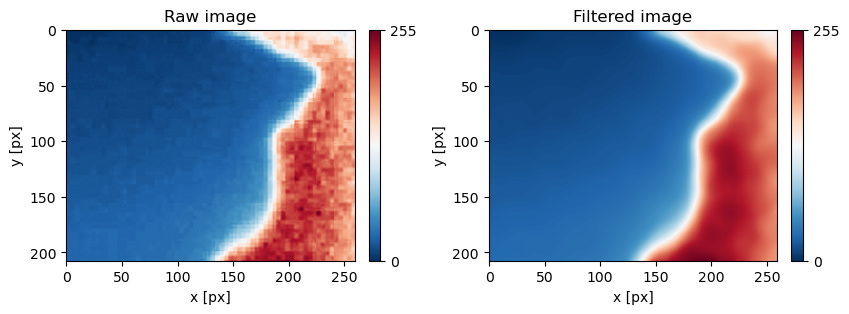

In [3]:
img = fun.filter(img_raw)

----
## 1+2) Gaussian filtering + Gradient computation
In this lab, we will combine steps 1 and 2 using the derivative theorem of convolution for faster computation time: 
\begin{align}
\nabla P = \nabla (G_{\sigma} \circledast I) =  (\nabla G_{\sigma}) \circledast I
\end{align}
\
Instead of filtering the image with a Gaussian kernel then computing the gradient, convolving it directly with a derivative of Gaussian (DoG) kernel produces the same result but faster.
\
\
In this stage, two parameters are typically required: the standard devation $\sigma$ of the Gaussian kernel and its width. Usually, the width is set a to product of the $\sigma$ (typically $4\sigma$). The kernel should sum up to one to ensure the mean image stays the same. Gradient computation is done by convolving the DoG kernel with the image across both the radial and axial directions, then combining both components of the gradient to obtain the magnitude. The two components can then be used to extract the direction of the gradient at every pixel which is essential to step 3 (non-maxima suppression).
\
\
*Note : For better visualization, the extent of both the Gaussian and DoG kernels is shown as a turquoise square in the top left-hand side of the 2D gradient figure down below.*

In [4]:
wg.interact(fun.filt_grad, img = wg.fixed(img), sigma = (2,11,1), flag = wg.fixed(1))

interactive(children=(IntSlider(value=2, description='sigma', max=11, min=2), Output()), _dom_classes=('widget…

<function lab2_functions.filt_grad(img, sigma=2, flag=0)>

As expected, higher values of $\sigma$ result in better noise reduction as the gradient is computed over a wider range of pixels. However, Gaussian filtering is not edge-preserving. Lower values of sigma $\sigma \sim 2-3$ are therefore advised while edge-preserving filters can be applied to the image before edge detection to eliminate some of the noise in the image.

----
## 3) Non-maxima suppression
In this stage, we will thin the gradient image by discarding non-local maxima. This is done by placing a $3\times3$ px$^2$ kernel at every pixel of the image, and only keeping local maxima in the direction of the gradient $\theta$ computed previously.

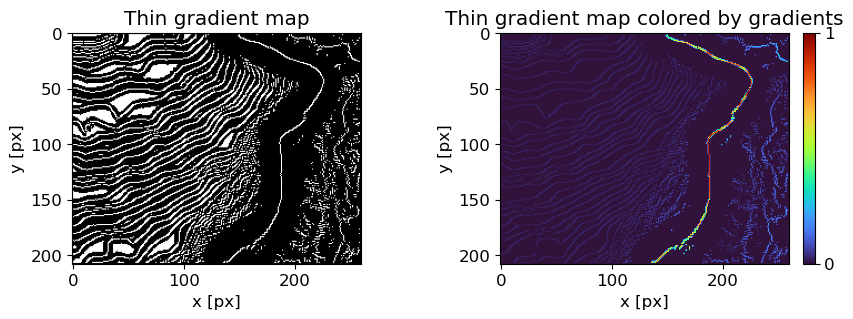

In [5]:
D, theta =  fun.filt_grad(img, sigma = 2, flag = 0)
T = fun.nms(D, theta)

----
## 4) Hysteresis thresholding
In the final stage of the algorithm, we will be using both the lower and higher threshold to extract the flame edge. There is, in principle, no easy or straight-forward way of predicting what combination of $t_{low}$ and $t_{high}$ will yield the "best" result so it will take some trial and error. The combination of thresholds will also depend on the quality of the images and the effectiveness of the pre-processing scheme implemented prior to this stage. For the image provided, however, changing the value of $t_{high}$ is sufficient. We will see how important the lower threshold $t_{low}$ is when dealing with low SNR images in the practical exercise.

In [6]:
wg.interact(fun.hysteresis_thresholding, T = wg.fixed(T), D = wg.fixed(D), t_high = (0,1,.05), t_low = (0, 1, .05))

interactive(children=(FloatSlider(value=0.0, description='t_high', max=1.0, step=0.05), FloatSlider(value=0.0,…

<function lab2_functions.hysteresis_thresholding(T, D, t_high=0, t_low=0)>

-----

# Conclusion
In this lab, we have looked at how Canny edge detection can be used for flame front detection. The algorithm is more developed than the standard Otsu segmentation algorithm presented previously but tends to produce more accurate results.

We can proceed next to a practical exercise where we apply both algorithms to low-SNR OH-PLIF images.